# Analysis of SARS-COV-2 virus neutalization in different Ace2 clones

This notebook analysis neutralization of SARS-COV-2/Wu-1 virus by sera from vaccinated individuals on 293T cell clones that express different levels of ACE2.

### Set up Analysis

In [1]:
import os
import warnings

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

Set seaborn theme:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data
We read in fraction infectivirty data for different cell lines and import sera information.

In [6]:
frac_infect = list() # create df list

for f in config['depletion_neuts'].keys():
    df = (pd.read_csv(f, index_col=0))
    frac_infect.append(df)  
frac_infect = pd.concat(frac_infect)



In [7]:
#read in sample info
sample_information = (pd.read_csv(config['sample_information'])
                      .drop_duplicates())

sample_information['sorted']=sample_information['subject_name'].str[:-1].astype(int)
sample_information = sample_information.sort_values('sorted')

#store sera names in a list to later convert to factors for plotting
cat_order_sera = sample_information['serum'].tolist()


In [8]:
sample_information

,day,age,vaccine,subject_name,serum_org,gender,serum,sorted
0,10,18-55y,Pfizer,63C,63C-day-10,Female,serum 1,63
1,15,>55y,Pfizer,64C,64C-day-15,Female,serum 2,64
2,27,18-55y,Pfizer,99C,99C-day-27,Male,serum 3,99
3,18,>55y,Pfizer,108C,108C-day-18,Female,serum 4,108
4,10,18-55y,Pfizer,120C,120C-day-10,Female,serum 5,120
5,36,18-55y,Moderna,180C,180C-day-36,Female,serum 6,180
6,9,>55y,Pfizer,192C,192C-day-9,Female,serum 7,192
7,8,18-55y,Pfizer,194C,194C-day-8,Male,serum 8,194
8,19,18-55y,Pfizer,215C,215C-day-19,Male,serum 9,215
9,29,18-55y,Pfizer,229C,229C-day-29,Female,serum 10,229


In [9]:
frac_infect = pd.merge(frac_infect, sample_information,
                    left_on='serum', right_on='serum_org')
frac_infect.drop('serum_x', axis=1, inplace=True)
frac_infect = frac_infect.rename(columns={"serum_y": "serum"}, errors="raise")


In [10]:
frac_infect['serum'] = frac_infect['serum'] + '__' + frac_infect['cells']

frac_infect['virus'] = frac_infect['virus'].str.replace('post-depletion','depleted')
frac_infect['virus'] = frac_infect['virus'].str.replace('pre-depletion','not depleted')


In [11]:
#read in ACE2 expression info
ACE2_expression_df = (pd.read_csv(config['ACE2_expression_df'])
                      .drop_duplicates())

## Fit Hill curve 

We use [`neutcurve`](https://jbloomlab.github.io/neutcurve/) to fit Hill curve for neutralization data and calcualte IC50 and NT50 values.

In [12]:
fits = neutcurve.CurveFits(frac_infect, fixbottom=0)

fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'RBD-targeting antibodies'})
    [['serum', 'RBD-targeting antibodies', 'ic50', 'ic50_bound']]
    .assign(NT50=lambda x: 1/x['ic50'])

    )

In [13]:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [14]:
fitparams[['sample', 'cells']] = fitparams['serum'].str.split('__', 1, expand=True)

In [15]:
#category for cell order so that ggplot does not use alphabetical
cat_order = ['very low', 'low', 'medium', 'high']
fitparams['cells'] = pd.Categorical(fitparams['cells'], categories=cat_order, ordered=True)

fitparams['sample'] = pd.Categorical(fitparams['sample'], categories=cat_order_sera, ordered=True)

In [16]:
#save data
fitparams.to_csv(config['neuts'], index=False)

In [17]:
#add % RBD-targetting antibodies
df_pre = fitparams.loc[fitparams['RBD-targeting antibodies'] == 'not depleted']
df_post = fitparams.loc[fitparams['RBD-targeting antibodies'] == 'depleted']
df_merge = pd.merge(df_pre, df_post, on="serum")
df_merge['NT50_fc'] = df_merge['NT50_x']/df_merge['NT50_y']
df_merge['NT50_fc'] = df_merge['NT50_fc'].astype(int)
fitparams = pd.merge(fitparams,df_merge[['serum','NT50_fc']],on='serum', how='left')
fitparams['NT50_fc_str'] = fitparams['NT50_fc'].astype(str)

In [18]:
NT50_fc = fitparams.loc[fitparams['RBD-targeting antibodies'] == 'depleted']

In [19]:
# add % RBD-targetting antibodies
df_pre = fitparams.loc[fitparams['RBD-targeting antibodies'] == 'not depleted']
df_post = fitparams.loc[fitparams['RBD-targeting antibodies'] == 'depleted']
df_merge = pd.merge(df_pre, df_post, on="serum")
df_merge['percent_RBD'] = (df_merge['NT50_x']-df_merge['NT50_y'])/df_merge['NT50_x']*100
df_merge['percent_RBD'] = df_merge['percent_RBD'].astype(int)
fitparams = pd.merge(fitparams,df_merge[['serum','percent_RBD']],on='serum', how='left')
fitparams['percent_RBD_str'] = fitparams['percent_RBD'].astype(str) +'%'


In [20]:
#how come not all of the NT50's which are at LOD show up as lower bound?
fitparams.loc[fitparams['ic50_is_bound'] == True]

,serum,RBD-targeting antibodies,ic50,ic50_bound,NT50,ic50_is_bound,sample,cells,NT50_fc,NT50_fc_str,percent_RBD,percent_RBD_str
15,serum 2__high,depleted,0.04,lower,25.0,True,serum 2,high,92,92,98,98%
23,serum 3__high,depleted,0.04,lower,25.0,True,serum 3,high,106,106,99,99%
63,serum 8__high,depleted,0.04,lower,25.0,True,serum 8,high,142,142,99,99%
71,serum 9__high,depleted,0.04,lower,25.0,True,serum 9,high,72,72,98,98%


In [21]:
rbd = fitparams.loc[fitparams['RBD-targeting antibodies'] == 'depleted']

## Plot IC50 values

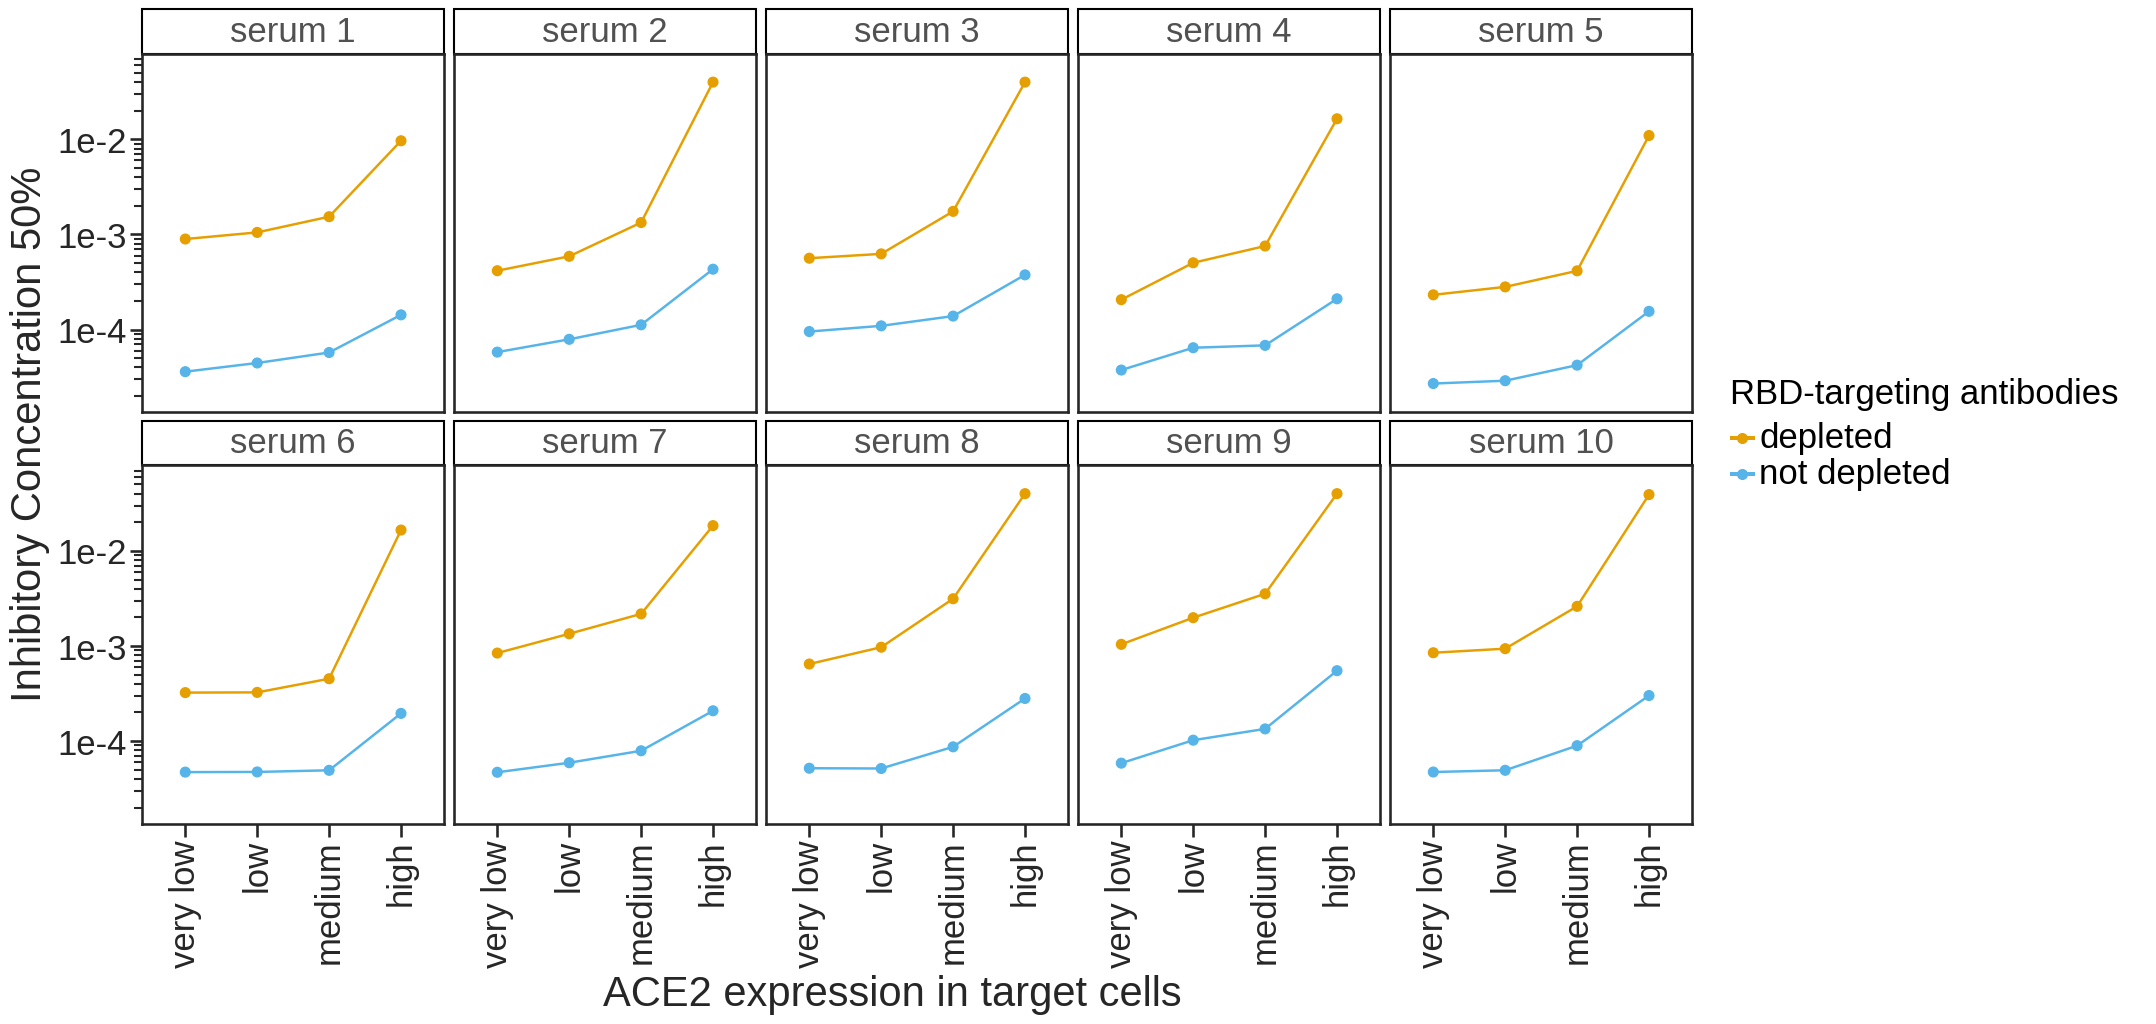

In [22]:
IC50 = (ggplot(fitparams, aes(x='cells',
                              y='ic50',
                              colour='RBD-targeting antibodies',
                              group = 'RBD-targeting antibodies',
                              )) +
              geom_point(size=3.5) +
              geom_line(size = 1) +
         #geom_text(NT50_fc, aes(label = 'NT50_fc_str',
                            #y=NT50_fc['ic50'].max()*2),
                   #size = 20,
                  #colour = CBPALETTE[0]) +
             theme(figure_size=(20,10),
                   axis_text=element_text(size=25),
                   axis_text_x=element_text(size=25, angle=90),
                   legend_text=element_text(size=25),
                   legend_title=element_text(size=25),
                   axis_title_x=element_text(size=30),
                   axis_title_y=element_text(size=30),
                   strip_text = element_text(size=25, alpha=0.8),
                   strip_background=element_rect(colour = "black", fill = "white"),
                   
                  ) +
              facet_wrap('sample', ncol = 5)+
              
              scale_y_log10(expand=(0, 0.3)) +
              ylab('Inhibitory Concentration 50%') +
              xlab('ACE2 expression in target cells') +
             scale_color_manual(values=CBPALETTE[1:])
                 )

_ = IC50.draw()
plt.savefig('IC50.pdf')

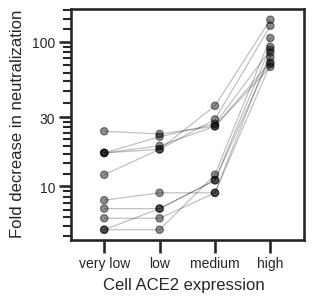

In [23]:
NT50_foldchange = (
              ggplot(fitparams, aes(x='cells',
                          y='NT50_fc',
                          group= 'sample')) +
              geom_point(size=2.5, alpha=0.25) +
              geom_line(alpha=0.25) +
             theme(
                   figure_size=(3,3),
                   axis_text=element_text(size=10),
                   axis_text_x=element_text(size=10),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10) 
                  ) +
              scale_y_log10(name='Fold decrease in neutralization') +
              xlab('Cell ACE2 expression')
)

NT50_foldchange.draw()
plt.savefig('NT50_change.pdf')

In [24]:
 fitparams

,serum,RBD-targeting antibodies,ic50,ic50_bound,NT50,ic50_is_bound,sample,cells,NT50_fc,NT50_fc_str,percent_RBD,percent_RBD_str
0,serum 1__very low,not depleted,0.000036,interpolated,27704.327914,False,serum 1,very low,24,24,95,95%
1,serum 1__very low,depleted,0.000896,interpolated,1116.350361,False,serum 1,very low,24,24,95,95%
2,serum 1__low,not depleted,0.000045,interpolated,22448.016607,False,serum 1,low,23,23,95,95%
3,serum 1__low,depleted,0.001052,interpolated,950.691112,False,serum 1,low,23,23,95,95%
4,serum 1__medium,not depleted,0.000057,interpolated,17424.490270,False,serum 1,medium,26,26,96,96%
...,...,...,...,...,...,...,...,...,...,...,...,...
75,serum 10__low,depleted,0.000938,interpolated,1066.495216,False,serum 10,low,18,18,94,94%
76,serum 10__medium,not depleted,0.000090,interpolated,11161.238349,False,serum 10,medium,29,29,96,96%
77,serum 10__medium,depleted,0.002613,interpolated,382.702173,False,serum 10,medium,29,29,96,96%
78,serum 10__high,not depleted,0.000301,interpolated,3317.975700,False,serum 10,high,129,129,99,99%


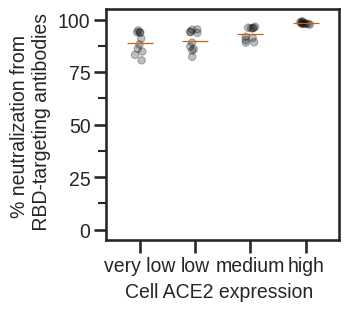

In [25]:
RBD_percentage = (
    ggplot(rbd, aes(x='cells',
                              y='percent_RBD')) +
              geom_jitter(size=2.5, alpha=0.25, position=position_jitter(0.1)) +
              stat_summary(geom = "point",
                           fun_data='mean_cl_boot',
                           size=10,
                           shape = "_",
                          colour = '#D55E00')+
             theme(figure_size=(3,3),
                   axis_text=element_text(size=14),
                   axis_text_x=element_text(size=14),
                   legend_text=element_text(size=14),
                   legend_title=element_text(size=14),
                   axis_title_x=element_text(size=14),
                   axis_title_y=element_text(size=14),
                   strip_text = element_text(size=14)
                  ) +
              ylim(0,100)+
              ylab('% neutralization from \n RBD-targeting antibodies')+
              xlab('Cell ACE2 expression') +
             scale_color_manual(values=CBPALETTE[1:])
             )

RBD_percentage.draw()
plt.savefig('RBD_percentage.pdf')

## Plot NT50 values

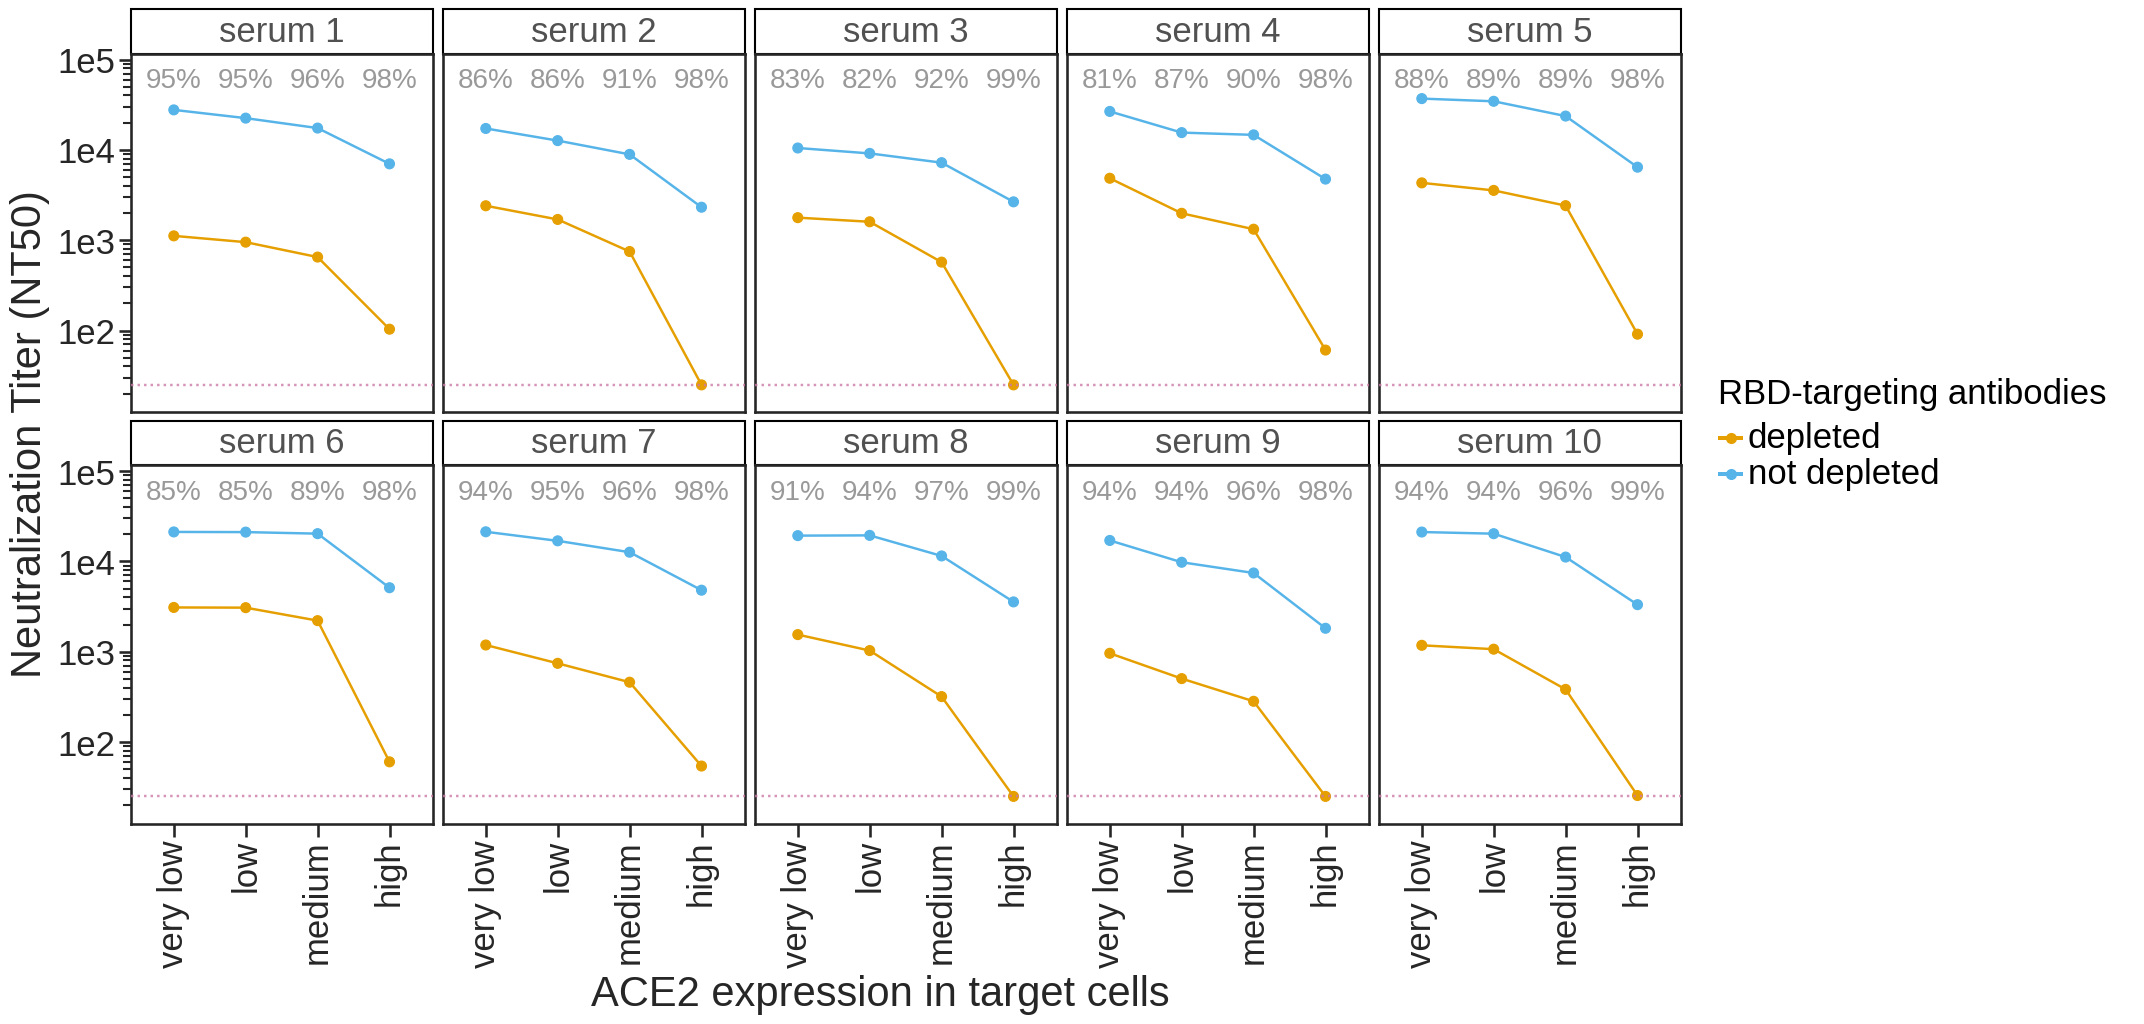

In [26]:
NT50 = (ggplot(fitparams, aes(x='cells', y='NT50', colour='RBD-targeting antibodies', group = 'RBD-targeting antibodies')) +
              geom_point(size=3.5) +
              geom_line(size = 1) +
         geom_text(rbd, aes(label = 'percent_RBD_str',
                   y=rbd['NT50'].max()*12),
                  size = 20,
                   colour = CBPALETTE[0]) +
         theme(figure_size=(20,10),
                   axis_text=element_text(size=25),
                   axis_text_x=element_text(size=25, angle=90),
                   legend_text=element_text(size=25),
                   legend_title=element_text(size=25),
                   axis_title_x=element_text(size=30),
                   axis_title_y=element_text(size=30),
                   strip_text = element_text(size=25, alpha=0.8),
                   strip_background=element_rect(colour = "black", fill = "white")
                   ) +
          geom_hline(yintercept=config['NT50_LOD'], 
                    linetype='dotted', 
                    size=1, 
                    alpha=0.8, 
                    color=CBPALETTE[7]
                    ) +
          facet_wrap('sample', ncol = 5)+
          scale_y_log10(expand=(0.03, .2)) +
              ylab('Neutralization Titer (NT50)') +
          xlab('ACE2 expression in target cells') +
          scale_color_manual(values=CBPALETTE[1:])
                )

_ = NT50.draw()

plt.savefig('NT50.pdf')

In [27]:
df_merged = pd.merge(fitparams, ACE2_expression_df, on='cells')

## Plot neut curves for all samples

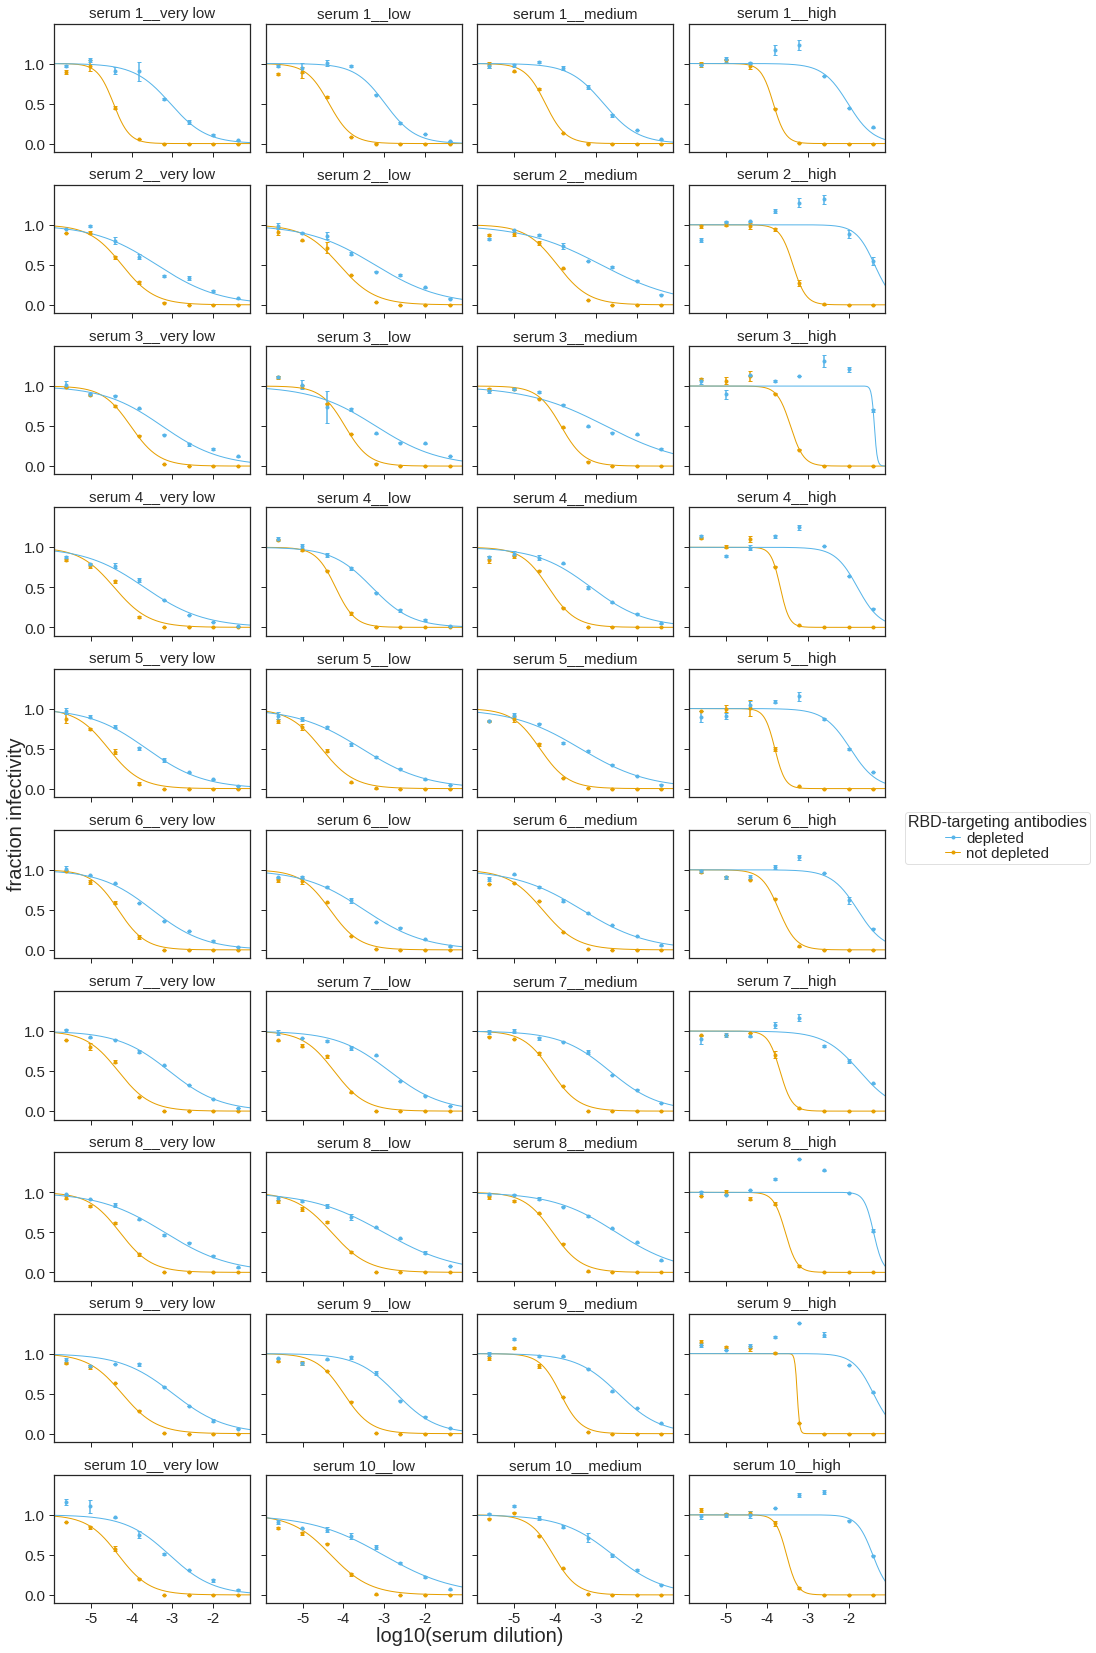

In [28]:
fig, axes = fits.plotSera(
                          xlabel='log10(serum dilution)',
                          widthscale=1, 
                          heightscale=1,
                          titlesize=15,
                          yticklocs=[0,0.5,1],
                          fix_lims={'ymax':1.5},
                          markersize=3, 
                          linewidth=1, 
                          labelsize=20,
                          ticksize=15, 
                          legendfontsize=15, 
                          ncol=4,
                          virus_to_color_marker={
                          'depleted': ('#56B4E9', 'o'),
                          'not depleted': ('#E69F00', 'o')},
                          legendtitle='RBD-targeting antibodies',
                    
                         )

_ = axes.ravel()[-1].set_xticks([1e-5, 1e-4, 1e-3, 1e-2])
_ = axes.ravel()[-1].set_xticklabels(['-5', '-4', '-3', '-2',])

plt.savefig('neutcurves.pdf')